In [1]:
from dotenv import load_dotenv, find_dotenv
from langchain.chat_models import init_chat_model
from langgraph.graph import StateGraph, END, START
from langgraph.prebuilt import create_react_agent
from langmem import create_manage_memory_tool, create_search_memory_tool
from typing import TypedDict, Literal, Annotated
from pydantic import BaseModel, Field
from langgraph.types import Command, interrupt
from langgraph.store.base import BaseStore
import openai 
from rich.markdown import Markdown
from datetime import datetime

In [2]:
_ = load_dotenv(find_dotenv())

In [3]:
user_profile = {
    "name": "Nnaemeka",
    "full_name": "Nnaemeka Nwankwo",
    "user_profile_background": "AI engineer. creating solutions with a AI agent leading a team of 3"
}

prompt_instructions = {
    "triage_rules": {
        "ignore": "Marketing newsletters, spam emails, mass company announcements",
        "notify": "Team member out sick, build system notifications, project status updates",
        "respond": "Direct questions from team members, meeting requests, critical bug reports",
    },
    "agent_instructions": "Use these tools when appropriate to help manage Nnaemeka's tasks efficiently."
}

triage_user_prompt = """
Please determine how to handle the below email thread:

From: {author}
To: {to}
Subject: {subject}
{email_thread}"""


default_cal_preferences = """
1 hour meetings are preferred, but 30 minute meetings are also acceptable.
"""

# Email assistant triage prompt 
triage_system_prompt = """

< Role >
Your role is to triage incoming emails based upon instructs and background information below.
</ Role >

< Background >
{background}. 
</ Background >

< Instructions >
Categorize each email into one of three categories:
1. IGNORE - Emails that are not worth responding to or tracking
2. NOTIFY - Important information that worth notification but doesn't require a response
3. RESPOND - Emails that need a direct response
Classify the below email into one of these categories.
</ Instructions >

< Rules >
{triage_instructions}
</ Rules >
"""

# Email assistant with HITL prompt 
agent_system_prompt_hitl_memory = """
< Role >
You are a top-notch executive assistant who cares about helping your executive perform as well as possible.
</ Role >

< Tools >
You have access to the following tools to help manage communications and schedule:
{tools_prompt}
</ Tools >

< Instructions >
When handling emails, follow these steps:
1. Carefully analyze the email content and purpose
2. IMPORTANT --- always call a tool and call one tool at a time until the task is complete: 
3. If the incoming email asks the user a direct question and you do not have context to answer the question, use the Question tool to ask the user for the answer
4. For responding to the email, draft a response email with the write_email tool
5. For meeting requests, use the check_calendar_availability tool to find open time slots
6. To schedule a meeting, use the schedule_meeting tool with a datetime object for the preferred_day parameter
   - Today's date is """ + datetime.now().strftime("%Y-%m-%d") + """ - use this for scheduling meetings accurately
7. If you scheduled a meeting, then draft a short response email using the write_email tool
8. After using the write_email tool, the task is complete
9. If you have sent the email, then use the Done tool to indicate that the task is complete
</ Instructions >

< Background >
{background}
</ Background >

< Response Preferences >
{response_preferences}
</ Response Preferences >

< Calendar Preferences >
{cal_preferences}
</ Calendar Preferences >
"""

In [4]:
MEMORY_UPDATE_INSTRUCTIONS = """
# Role and Objective
You are a memory profile manager for an email assistant agent that selectively updates user preferences based on feedback messages from human-in-the-loop interactions with the email assistant.

# Instructions
- NEVER overwrite the entire memory profile
- ONLY make targeted additions of new information
- ONLY update specific facts that are directly contradicted by feedback messages
- PRESERVE all other existing information in the profile
- Format the profile consistently with the original style
- Generate the profile as a string

# Reasoning Steps
1. Analyze the current memory profile structure and content
2. Review feedback messages from human-in-the-loop interactions
3. Extract relevant user preferences from these feedback messages (such as edits to emails/calendar invites, explicit feedback on assistant performance, user decisions to ignore certain emails)
4. Compare new information against existing profile
5. Identify only specific facts to add or update
6. Preserve all other existing information
7. Output the complete updated profile

# Example
<memory_profile>
RESPOND:
- wife
- specific questions
- system admin notifications
NOTIFY: 
- meeting invites
IGNORE:
- marketing emails
- company-wide announcements
- messages meant for other teams
</memory_profile>

<user_messages>
"The assistant shouldn't have responded to that system admin notification."
</user_messages>

<updated_profile>
RESPOND:
- wife
- specific questions
NOTIFY: 
- meeting invites
- system admin notifications
IGNORE:
- marketing emails
- company-wide announcements
- messages meant for other teams
</updated_profile>

# Process current profile for {namespace}
<memory_profile>
{current_profile}
</memory_profile>

Think step by step about what specific feedback is being provided and what specific information should be added or updated in the profile while preserving everything else.

Think carefully and update the memory profile based upon these user messages:"""


MEMORY_UPDATE_INSTRUCTIONS_REINFORCEMENT = """
Remember:
- NEVER overwrite the entire memory profile
- ONLY make targeted additions of new information
- ONLY update specific facts that are directly contradicted by feedback messages
- PRESERVE all other existing information in the profile
- Format the profile consistently with the original style
- Generate the profile as a string
"""


# Default response preferences 
default_response_preferences = """
Use professional and concise language. If the e-mail mentions a deadline, make sure to explicitly acknowledge and reference the deadline in your response.

When responding to technical questions that require investigation:
- Clearly state whether you will investigate or who you will ask
- Provide an estimated timeline for when you'll have more information or complete the task

When responding to event or conference invitations:
- Always acknowledge any mentioned deadlines (particularly registration deadlines)
- If workshops or specific topics are mentioned, ask for more specific details about them
- If discounts (group or early bird) are mentioned, explicitly request information about them
- Don't commit 

When responding to collaboration or project-related requests:
- Acknowledge any existing work or materials mentioned (drafts, slides, documents, etc.)
- Explicitly mention reviewing these materials before or during the meeting
- When scheduling meetings, clearly state the specific day, date, and time proposed

When responding to meeting scheduling requests:
- If times are proposed, verify calendar availability for all time slots mentioned in the original email and then commit to one of the proposed times based on your availability by scheduling the meeting. Or, say you can't make it at the time proposed.
- If no times are proposed, then check your calendar for availability and propose multiple time options when available instead of selecting just one.
- Mention the meeting duration in your response to confirm you've noted it correctly.
- Reference the meeting's purpose in your response.
"""
# Tool descriptions for HITL with memory workflow
# Note: Additional memory specific tools could be added here 
HITL_MEMORY_TOOLS_PROMPT = """
1. write_email(to, subject, content) - Send emails to specified recipients
2. schedule_meeting(attendees, subject, duration_minutes, preferred_day, start_time) - Schedule calendar meetings where preferred_day is a datetime object
3. check_calendar_availability(day) - Check available time slots for a given day
4. Question(content) - Ask the user any follow-up questions
5. Done - E-mail has been sent
"""

# Default triage instructions 
default_triage_instructions = """
Emails that are not worth responding to:
- Marketing newsletters and promotional emails
- Spam or suspicious emails
- CC'd on FYI threads with no direct questions

There are also other things that should be known about, but don't require an email response. For these, you should notify (using the `notify` response). Examples of this include:
- Team member out sick or on vacation
- Build system notifications or deployments
- Project status updates without action items
- Important company announcements
- FYI emails that contain relevant information for current projects
- HR Department deadline reminders
- Subscription status / renewal reminders
- GitHub notifications

Emails that are worth responding to:
- Direct questions from team members requiring expertise
- Meeting requests requiring confirmation
- Critical bug reports related to team's projects
- Requests from management requiring acknowledgment
- Client inquiries about project status or features
- Technical questions about documentation, code, or APIs (especially questions about missing endpoints or features)
- Personal reminders related to family (wife / daughter)
- Personal reminder related to self-care (doctor appointments, etc)
"""

In [5]:
# Agent tools 
from langchain_core.tools import tool
from datetime import datetime
@tool
def write_email(to: str, subject: str, content: str) -> str:
    """Write and send an email."""
    # Placeholder response - in real app would send email
    return f"Email sent to {to} with subject '{subject}' and content: {content}"

@tool
def schedule_meeting(
    attendees: list[str], subject: str, duration_minutes: int, preferred_day: datetime, start_time: int
) -> str:
    """Schedule a calendar meeting."""
    # Placeholder response - in real app would check calendar and schedule
    date_str = preferred_day.strftime("%A, %B %d, %Y")
    return f"Meeting '{subject}' scheduled on {date_str} at {start_time} for {duration_minutes} minutes with {len(attendees)} attendees"

@tool
def check_calendar_availability(day: str) -> str:
    """Check calendar availability for a given day."""
    # Placeholder response - in real app would check actual calendar
    return f"Available times on {day}: 9:00 AM, 2:00 PM, 4:00 PM"

@tool
class Question(BaseModel):
      """Question to ask user."""
      content: str

@tool
class Done(BaseModel):
      """E-mail has been sent."""
      done: bool


class Router(BaseModel):
    """Analyzed the unreead email and classify it according to it contents."""
    description: str = Field(description="step by step reasoning behind choosing the classification")
    classification: Literal["ignore", "notify", "respond"] = Field(
        description="The classification of the email there are only 3 possible class:" \
        "1. ignore: for irrelevant emails that does not need a response" \
        "2. notify: for important emails that doesn't need a response" \
        "3. respond: for important emails that also needs to be replied and attended to.")

    
# All tools available to the agent
tools = [
    write_email, 
    schedule_meeting, 
    check_calendar_availability, 
    Question, 
    Done
]

tools_by_name = {tool.name: tool for tool in tools}

# Initialize the LLM for use with router / structured output
llm = init_chat_model("openai:gpt-4.1", temperature=0.0)
llm_router = llm.with_structured_output(Router) 

# Initialize the LLM, enforcing tool use (of any available tools) for agent
llm = init_chat_model("openai:gpt-4.1", temperature=0.0)
llm_with_tools = llm.bind_tools(tools, tool_choice="required")

In [6]:
def get_memory(store, namespace, default_content=None):
    """Get memory from the store or initialize with default if it doesn't exist.
    
    Args:
        store: LangGraph BaseStore instance to search for existing memory
        namespace: Tuple defining the memory namespace, e.g. ("email_assistant", "triage_preferences")
        default_content: Default content to use if memory doesn't exist
        
    Returns:
        str: The content of the memory profile, either from existing memory or the default
    """
    # Search for existing memory with namespace and key
    user_preferences = store.get(namespace, "user_preferences")
    
    # If memory exists, return its content (the value)
    if user_preferences:
        return user_preferences.value
    
    # If memory doesn't exist, add it to the store and return the default content
    else:
        # Namespace, key, value
        store.put(namespace, "user_preferences", default_content)
        user_preferences = default_content
    
    # Return the default content
    return user_preferences

class UserPreferences(BaseModel):
    """Updated user preferences based on user's feedback."""
    chain_of_thought: str = Field(description="Reasoning about which user preferences need to add / update if required")
    user_preferences: str = Field(description="Updated user preferences")

def update_memory(store, namespace, messages):
    """Update memory profile in the store.
    
    Args:
        store: LangGraph BaseStore instance to update memory
        namespace: Tuple defining the memory namespace, e.g. ("email_assistant", "triage_preferences")
        messages: List of messages to update the memory with
    """

    # Get the existing memory
    user_preferences = store.get(namespace, "user_preferences")

    # Update the memory
    llm = init_chat_model("openai:gpt-4.1", temperature=0.0).with_structured_output(UserPreferences)
    result = llm.invoke(
        [
            {"role": "system", "content": MEMORY_UPDATE_INSTRUCTIONS.format(current_profile=user_preferences.value, namespace=namespace)},
        ] + messages
    )
    
    # Save the updated memory to the store
    store.put(namespace, "user_preferences", result.user_preferences)

In [7]:
def format_email(subject, author, to, email_thread, email_id=None):
    """Format email details into a nicely formatted markdown string for display
    
    Args:
        subject: Email subject
        author: Email sender
        to: Email recipient
        email_thread: Email content
        email_id: Optional email ID (for Gmail API)
    """
    id_section = f"\n**ID**: {email_id}" if email_id else ""
    
    return f"""

        **Subject**: {subject}
        **From**: {author}
        **To**: {to}{id_section}
        
        {email_thread}
        
        ---
        """

def parse_email(email: dict)-> tuple:
    author = email['author']
    to = email['to']
    subject = email['subject']
    email_thread = email['email_thread']
    return author, to, subject, email_thread

In [8]:
def format_for_display(tool_call):
    """Format content for display in Agent Inbox
    
    Args:
        tool_call: The tool call to format
    """
    # Initialize empty display
    display = ""
    
    # Add tool call information
    if tool_call["name"] == "write_email":
        display += f"""# Email Draft

**To**: {tool_call["args"].get("to")}
**Subject**: {tool_call["args"].get("subject")}

{tool_call["args"].get("content")}
"""
    elif tool_call["name"] == "schedule_meeting":
        display += f"""# Calendar Invite

**Meeting**: {tool_call["args"].get("subject")}
**Attendees**: {', '.join(tool_call["args"].get("attendees"))}
**Duration**: {tool_call["args"].get("duration_minutes")} minutes
**Day**: {tool_call["args"].get("preferred_day")}
"""
    elif tool_call["name"] == "Question":
        # Special formatting for questions to make them clear
        display += f"""# Question for User

{tool_call["args"].get("content")}
"""
    else:
        # Generic format for other tools
        display += f"""# Tool Call: {tool_call["name"]}

Arguments:"""
        
        # Check if args is a dictionary or string
        if isinstance(tool_call["args"], dict):
            display += f"\n{json.dumps(tool_call['args'], indent=2)}\n"
        else:
            display += f"\n{tool_call['args']}\n"
    return display


In [9]:
from langgraph.graph import add_messages, MessagesState

class State(TypedDict):
    email_input: dict
    messages: Annotated[list, add_messages]

# This state class extends the MessagesState
class TriageState(MessagesState):
    email_input: dict
    classification_decision: Literal["ignore", "respond", "notify"]

In [10]:
def triage_router(state: TriageState, store: BaseStore) -> Command[Literal["triage_interrupt_handler", "response_agent", "__end__"]]:
    """Analyze email content to decide if we should respond, notify, or ignore.

    The triage step prevents the assistant from wasting time on:
    - Marketing emails and spam
    - Company-wide announcements
    - Messages meant for other teams
    """
    # Parse the email input
    author, to, subject, email_thread = parse_email(state["email_input"])
    user_prompt = triage_user_prompt.format(
        author=author, to=to, subject=subject, email_thread=email_thread
    )

    # Create email markdown for Agent Inbox in case of notification  
    email = format_email(subject, author, to, email_thread)

    # Search for existing triage_preferences memory
    triage_instructions = get_memory(store, ("email_assistant", "triage_preferences"), default_triage_instructions)

    # Format system prompt with background and triage instructions
    system_prompt = triage_system_prompt.format(
        background=user_profile["user_profile_background"],
        triage_instructions=triage_instructions,
    )

    # Run the router LLM
    result = llm_router.invoke(
        [
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt},
        ]
    )

    # Decision
    classification = result.classification

    # Process the classification decision
    if classification == "respond":
        print("📧 Classification: RESPOND - This email requires a response")
        # Next node
        goto = "response_agent"
        # Update the state
        update = {
            "classification_decision": result.classification,
            "messages": [{"role": "user",
                            "content": f"Respond to the email: {email}"
                        }],
        }
        
    elif classification == "ignore":
        print("🚫 Classification: IGNORE - This email can be safely ignored")

        # Next node
        goto = END
        # Update the state
        update = {
            "classification_decision": classification,
        }

    elif classification == "notify":
        print("🔔 Classification: NOTIFY - This email contains important information") 

        # Next node
        goto = "triage_interrupt_handler"
        # Update the state
        update = {
            "classification_decision": classification,
        }

    else:
        raise ValueError(f"Invalid classification: {classification}")
    
    return Command(goto=goto, update=update)


In [11]:
def triage_interrupt_handler(state: State, store: BaseStore) -> Command[Literal["response_agent", "__end__"]]:
    """Handles interrupts from the triage step"""
    
    # Parse the email input
    author, to, subject, email_thread = parse_email(state["email_input"])

    # Create email markdown for Agent Inbox in case of notification  
    email = format_email(subject, author, to, email_thread)

    # Create messages
    messages = [{"role": "user",
                "content": f"Email to notify user about: {email}"
                }]

    # Create interrupt for Agent Inbox
    request = {
        "action_request": {
            "action": f"Email Assistant: {state['classification_decision']}",
            "args": {}
        },
        "config": {
            "allow_ignore": True,  
            "allow_respond": True,
            "allow_edit": False, 
            "allow_accept": False,  
        },
        # Email to show in Agent Inbox
        "description": email,
    }

    # Send to Agent Inbox and wait for response
    response = interrupt([request])[0]

    # If user provides feedback, go to response agent and use feedback to respond to email   
    if response["type"] == "response":
        # Add feedback to messages 
        user_input = response["args"]
        messages.append({"role": "user",
                        "content": f"User wants to reply to the email. Use this feedback to respond: {user_input}"
                        })
        # This is new: update triage_preferences with feedback
        update_memory(store, ("email_assistant", "triage_preferences"), [{
            "role": "user",
            "content": f"The user decided to respond to the email, so update the triage preferences to capture this."
        }] + messages)

        goto = "response_agent"

    # If user ignores email, go to END
    elif response["type"] == "ignore":
        # Make note of the user's decision to ignore the email
        messages.append({"role": "user",
                        "content": f"The user decided to ignore the email even though it was classified as notify. Update triage preferences to capture this."
                        })
        # This is new: triage_preferences with feedback
        update_memory(store, ("email_assistant", "triage_preferences"), messages)
        goto = END

    # Catch all other responses
    else:
        raise ValueError(f"Invalid response: {response}")

    # Update the state 
    update = {
        "messages": messages,
    }

    return Command(goto=goto, update=update)

In [12]:
def llm_call(state: State, store: BaseStore):
    """LLM decides whether to call a tool or not"""

    # Search for existing cal_preferences memory
    cal_preferences = get_memory(store, ("email_assistant", "cal_preferences"), default_cal_preferences)
    
    # Search for existing response_preferences memory
    response_preferences = get_memory(store, ("email_assistant", "response_preferences"), default_response_preferences)

    return {
        "messages": [
            llm_with_tools.invoke(
                [
                    {"role": "system", "content": agent_system_prompt_hitl_memory.format(tools_prompt=HITL_MEMORY_TOOLS_PROMPT,
                                                                                         background=user_profile['user_profile_background'],
                                                                                         response_preferences=response_preferences, 
                                                                                         cal_preferences=cal_preferences)}
                ]
                + state["messages"]
            )
        ]
    }

In [13]:
def interrupt_handler(state: State, store: BaseStore) -> Command[Literal["llm_call", "__end__"]]:
    """Creates an interrupt for human review of tool calls"""
    
    # Store messages
    result = []

    # Go to the LLM call node next
    goto = "llm_call"

    # Iterate over the tool calls in the last message
    for tool_call in state["messages"][-1].tool_calls:
        
        # Allowed tools for HITL
        hitl_tools = ["write_email", "schedule_meeting", "Question"]
        
        # If tool is not in our HITL list, execute it directly without interruption
        if tool_call["name"] not in hitl_tools:

            # Execute tool without interruption
            tool = tools_by_name[tool_call["name"]]
            observation = tool.invoke(tool_call["args"])
            result.append({"role": "tool", "content": observation, "tool_call_id": tool_call["id"]})
            continue
            
        # Get original email from email_input in state
        email_input = state["email_input"]
        author, to, subject, email_thread = parse_email(email_input)
        original_email_markdown = format_email(subject, author, to, email_thread)
        
        # Format tool call for display and prepend the original email
        tool_display = format_for_display(tool_call)
        description = original_email_markdown + tool_display

        # Configure what actions are allowed in Agent Inbox
        if tool_call["name"] == "write_email":
            config = {
                "allow_ignore": True,
                "allow_respond": True,
                "allow_edit": True,
                "allow_accept": True,
            }
        elif tool_call["name"] == "schedule_meeting":
            config = {
                "allow_ignore": True,
                "allow_respond": True,
                "allow_edit": True,
                "allow_accept": True,
            }
        elif tool_call["name"] == "Question":
            config = {
                "allow_ignore": True,
                "allow_respond": True,
                "allow_edit": False,
                "allow_accept": False,
            }
        else:
            raise ValueError(f"Invalid tool call: {tool_call['name']}")

        # Create the interrupt request
        request = {
            "action_request": {
                "action": tool_call["name"],
                "args": tool_call["args"]
            },
            "config": config,
            "description": description,
        }

        # Send to Agent Inbox and wait for response
        response = interrupt([request])[0]

        # Handle the responses 
        if response["type"] == "accept":

            # Execute the tool with original args
            tool = tools_by_name[tool_call["name"]]
            observation = tool.invoke(tool_call["args"])
            result.append({"role": "tool", "content": observation, "tool_call_id": tool_call["id"]})
                        
        elif response["type"] == "edit":

            # Tool selection 
            tool = tools_by_name[tool_call["name"]]
            initial_tool_call = tool_call["args"]
            
            # Get edited args from Agent Inbox
            edited_args = response["args"]["args"]

            # Update the AI message's tool call with edited content (reference to the message in the state)
            ai_message = state["messages"][-1] # Get the most recent message from the state
            current_id = tool_call["id"] # Store the ID of the tool call being edited
            
            # Create a new list of tool calls by filtering out the one being edited and adding the updated version
            # This avoids modifying the original list directly (immutable approach)
            updated_tool_calls = [tc for tc in ai_message.tool_calls if tc["id"] != current_id] + [
                {"type": "tool_call", "name": tool_call["name"], "args": edited_args, "id": current_id}
            ]

            # Create a new copy of the message with updated tool calls rather than modifying the original
            # This ensures state immutability and prevents side effects in other parts of the code
            # When we update the messages state key ("messages": result), the add_messages reducer will
            # overwrite existing messages by id and we take advantage of this here to update the tool calls.
            result.append(ai_message.model_copy(update={"tool_calls": updated_tool_calls}))

            # Save feedback in memory and update the write_email tool call with the edited content from Agent Inbox
            if tool_call["name"] == "write_email":
                
                # Execute the tool with edited args
                observation = tool.invoke(edited_args)
                
                # Add only the tool response message
                result.append({"role": "tool", "content": observation, "tool_call_id": current_id})

                # This is new: update the memory
                update_memory(store, ("email_assistant", "response_preferences"), [{
                    "role": "user",
                    "content": f"User edited the email response. Here is the initial email generated by the assistant: {initial_tool_call}. Here is the edited email: {edited_args}. Follow all instructions above, and remember: {MEMORY_UPDATE_INSTRUCTIONS_REINFORCEMENT}."
                }])
            
            # Save feedback in memory and update the schedule_meeting tool call with the edited content from Agent Inbox
            elif tool_call["name"] == "schedule_meeting":
                
                # Execute the tool with edited args
                observation = tool.invoke(edited_args)
                
                # Add only the tool response message
                result.append({"role": "tool", "content": observation, "tool_call_id": current_id})

                # This is new: update the memory
                update_memory(store, ("email_assistant", "cal_preferences"), [{
                    "role": "user",
                    "content": f"User edited the calendar invitation. Here is the initial calendar invitation generated by the assistant: {initial_tool_call}. Here is the edited calendar invitation: {edited_args}. Follow all instructions above, and remember: {MEMORY_UPDATE_INSTRUCTIONS_REINFORCEMENT}."
                }])
            
            # Catch all other tool calls
            else:
                raise ValueError(f"Invalid tool call: {tool_call['name']}")

        elif response["type"] == "ignore":

            if tool_call["name"] == "write_email":
                # Don't execute the tool, and tell the agent how to proceed
                result.append({"role": "tool", "content": "User ignored this email draft. Ignore this email and end the workflow.", "tool_call_id": tool_call["id"]})
                # Go to END
                goto = END
                # This is new: update the memory
                update_memory(store, ("email_assistant", "triage_preferences"), state["messages"] + result + [{
                    "role": "user",
                    "content": f"The user ignored the email draft. That means they did not want to respond to the email. Update the triage preferences to ensure emails of this type are not classified as respond. Follow all instructions above, and remember: {MEMORY_UPDATE_INSTRUCTIONS_REINFORCEMENT}."
                }])

            elif tool_call["name"] == "schedule_meeting":
                # Don't execute the tool, and tell the agent how to proceed
                result.append({"role": "tool", "content": "User ignored this calendar meeting draft. Ignore this email and end the workflow.", "tool_call_id": tool_call["id"]})
                # Go to END
                goto = END
                # This is new: update the memory
                update_memory(store, ("email_assistant", "triage_preferences"), state["messages"] + result + [{
                    "role": "user",
                    "content": f"The user ignored the calendar meeting draft. That means they did not want to schedule a meeting for this email. Update the triage preferences to ensure emails of this type are not classified as respond. Follow all instructions above, and remember: {MEMORY_UPDATE_INSTRUCTIONS_REINFORCEMENT}."
                }])

            elif tool_call["name"] == "Question":
                # Don't execute the tool, and tell the agent how to proceed
                result.append({"role": "tool", "content": "User ignored this question. Ignore this email and end the workflow.", "tool_call_id": tool_call["id"]})
                # Go to END
                goto = END
                # This is new: update the memory
                update_memory(store, ("email_assistant", "triage_preferences"), state["messages"] + result + [{
                    "role": "user",
                    "content": f"The user ignored the Question. That means they did not want to answer the question or deal with this email. Update the triage preferences to ensure emails of this type are not classified as respond. Follow all instructions above, and remember: {MEMORY_UPDATE_INSTRUCTIONS_REINFORCEMENT}."
                }])

            else:
                raise ValueError(f"Invalid tool call: {tool_call['name']}")

        elif response["type"] == "response":
            # User provided feedback
            user_feedback = response["args"]
            if tool_call["name"] == "write_email":
                # Don't execute the tool, and add a message with the user feedback to incorporate into the email
                result.append({"role": "tool", "content": f"User gave feedback, which can we incorporate into the email. Feedback: {user_feedback}", "tool_call_id": tool_call["id"]})
                # This is new: update the memory
                update_memory(store, ("email_assistant", "response_preferences"), state["messages"] + result + [{
                    "role": "user",
                    "content": f"User gave feedback, which we can use to update the response preferences. Follow all instructions above, and remember: {MEMORY_UPDATE_INSTRUCTIONS_REINFORCEMENT}."
                }])

            elif tool_call["name"] == "schedule_meeting":
                # Don't execute the tool, and add a message with the user feedback to incorporate into the email
                result.append({"role": "tool", "content": f"User gave feedback, which can we incorporate into the meeting request. Feedback: {user_feedback}", "tool_call_id": tool_call["id"]})
                # This is new: update the memory
                update_memory(store, ("email_assistant", "cal_preferences"), state["messages"] + result + [{
                    "role": "user",
                    "content": f"User gave feedback, which we can use to update the calendar preferences. Follow all instructions above, and remember: {MEMORY_UPDATE_INSTRUCTIONS_REINFORCEMENT}."
                }])

            elif tool_call["name"] == "Question":
                # Don't execute the tool, and add a message with the user feedback to incorporate into the email
                result.append({"role": "tool", "content": f"User answered the question, which can we can use for any follow up actions. Feedback: {user_feedback}", "tool_call_id": tool_call["id"]})

            else:
                raise ValueError(f"Invalid tool call: {tool_call['name']}")

    # Update the state 
    update = {
        "messages": result,
    }

    return Command(goto=goto, update=update)

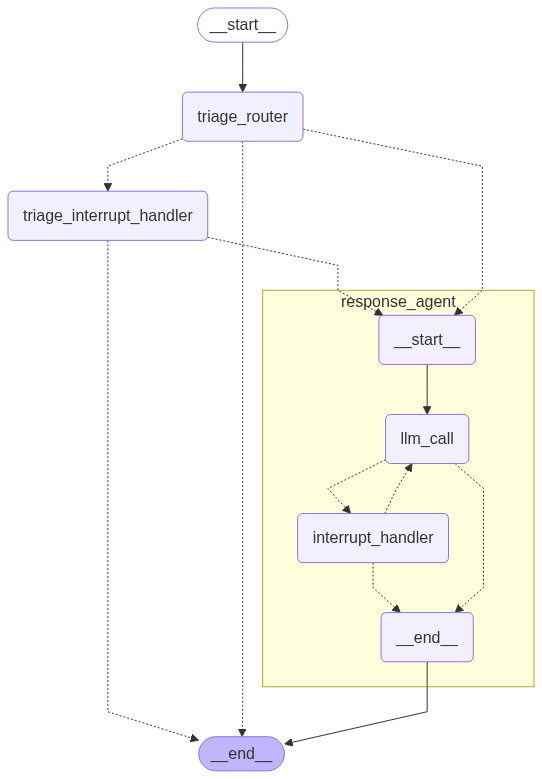

In [14]:
from IPython.display import Image, display


class StateInput(TypedDict):
    # This is the input to the state
    email_input: dict
# Conditional edge function
def should_continue(state: State, store: BaseStore) -> Literal["interrupt_handler", END]:
    """Route to tool handler, or end if Done tool called"""
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        for tool_call in last_message.tool_calls: 
            if tool_call["name"] == "Done":
                return END
            else:
                return "interrupt_handler"

# Build workflow
agent_builder = StateGraph(State)

# Add nodes - with store parameter
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("interrupt_handler", interrupt_handler)

# Add edges
agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges(
    "llm_call",
    should_continue,
    {
        "interrupt_handler": "interrupt_handler",
        END: END,
    },
)

# Compile the agent
response_agent = agent_builder.compile()

# Build overall workflow with store and checkpointer
overall_workflow = (
    StateGraph(TriageState, input_schema=StateInput)
    .add_node(triage_router)
    .add_node(triage_interrupt_handler)
    .add_node("response_agent", response_agent)
    .add_edge(START, "triage_router")
)

email_assistant = overall_workflow.compile()
display(Image(email_assistant.get_graph(xray=True).draw_mermaid_png()))

In [15]:
import uuid 
from langgraph.checkpoint.memory import MemorySaver
from langgraph.types import Command
from langgraph.store.memory import InMemoryStore

# Helper function to display memory content
def display_memory_content(store, namespace=None):
    # Display current memory content for all namespaces
    print("\n======= CURRENT MEMORY CONTENT =======")
    if namespace:
        memory = store.get(namespace, "user_preferences")
        if memory:
            print(f"\n--- {namespace[1]} ---")
            print(memory.value)
        else:
            print(f"\n--- {namespace[1]} ---")
            print("No memory found")
    else:
        for namespace in [
            ("email_assistant", "triage_preferences"),
            ("email_assistant", "response_preferences"),
            ("email_assistant", "cal_preferences"),
            ("email_assistant", "background")
        ]:
            memory = store.get(namespace, "user_preferences")
            if memory:
                print(f"\n--- {namespace[1]} ---")
                print(memory.value)
            else:
                print(f"\n--- {namespace[1]} ---")
                print("No memory found")
            print("=======================================\n")

In [16]:
# Respond - Meeting Request Email
email_input_respond = {
    "to": "Lance Martin <lance@company.com>",
    "author": "Project Manager <pm@client.com>",
    "subject": "Tax season let's schedule call",
    "email_thread": "Lance,\n\nIt's tax season again, and I wanted to schedule a call to discuss your tax planning strategies for this year. I have some suggestions that could potentially save you money.\n\nAre you available sometime next week? Tuesday or Thursday afternoon would work best for me, for about 45 minutes.\n\nRegards,\nProject Manager"
}

# Compile the graph
checkpointer = MemorySaver()
store = InMemoryStore()
graph = overall_workflow.compile(checkpointer=checkpointer, store=store)
thread_id_1 = uuid.uuid4()
thread_config_1 = {"configurable": {"thread_id": thread_id_1}}

# Run the graph until the first interrupt 
# Email will be classified as "respond" 
# Agent will create a schedule_meeting and write_email tool call
print("Running the graph until the first interrupt...")
for chunk in graph.stream({"email_input": email_input_respond}, config=thread_config_1):
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")

# Check memory after first interrupt
display_memory_content(store)

Running the graph until the first interrupt...
📧 Classification: RESPOND - This email requires a response

INTERRUPT OBJECT:
Action Request: {'action': 'schedule_meeting', 'args': {'attendees': ['pm@client.com'], 'subject': 'Tax Planning Strategies Discussion', 'duration_minutes': 45, 'preferred_day': '2025-07-22', 'start_time': 14}}

======= CURRENT MEMORY CONTENT =======

--- triage_preferences ---

Emails that are not worth responding to:
- Marketing newsletters and promotional emails
- Spam or suspicious emails
- CC'd on FYI threads with no direct questions

There are also other things that should be known about, but don't require an email response. For these, you should notify (using the `notify` response). Examples of this include:
- Team member out sick or on vacation
- Build system notifications or deployments
- Project status updates without action items
- Important company announcements
- FYI emails that contain relevant information for current projects
- HR Department deadli

In [17]:
print(f"\nSimulating user accepting the {Interrupt_Object.value[0]['action_request']['action']} tool call...")
for chunk in graph.stream(Command(resume=[{"type": "accept"}]), config=thread_config_1):
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")


Simulating user accepting the schedule_meeting tool call...

INTERRUPT OBJECT:
Action Request: {'action': 'write_email', 'args': {'to': 'pm@client.com', 'subject': "Re: Tax season let's schedule call", 'content': 'Hello,\n\nThank you for reaching out. I have scheduled our call to discuss tax planning strategies for Tuesday, July 22nd at 2:00 PM, for 45 minutes. Please let me know if this time does not work for you, and I can suggest alternative slots on Tuesday or Thursday afternoon.\n\nLooking forward to your suggestions.\n\nBest regards,\nLance'}}


In [18]:
print(f"\nSimulating user accepting the {Interrupt_Object.value[0]['action_request']['action']} tool call...")
for chunk in graph.stream(Command(resume=[{"type": "accept"}]), config=thread_config_1):
    # Inspect response_agent most recent message
    if 'response_agent' in chunk:
        chunk['response_agent']['messages'][-1].pretty_print()
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")

# Check memory after accepting the write_email tool call
display_memory_content(store)


Simulating user accepting the write_email tool call...
================================== Ai Message ==================================
Tool Calls:
  Done (call_hQFGm7az9Il5o97MH3ODBlIi)
 Call ID: call_hQFGm7az9Il5o97MH3ODBlIi
  Args:
    done: True

======= CURRENT MEMORY CONTENT =======

--- triage_preferences ---

Emails that are not worth responding to:
- Marketing newsletters and promotional emails
- Spam or suspicious emails
- CC'd on FYI threads with no direct questions

There are also other things that should be known about, but don't require an email response. For these, you should notify (using the `notify` response). Examples of this include:
- Team member out sick or on vacation
- Build system notifications or deployments
- Project status updates without action items
- Important company announcements
- FYI emails that contain relevant information for current projects
- HR Department deadline reminders
- Subscription status / renewal reminders
- GitHub notifications

Emails

In [19]:
state = graph.get_state(thread_config_1)
for m in state.values['messages']:
    m.pretty_print()

================================ Human Message =================================

Respond to the email: 

        **Subject**: Tax season let's schedule call
        **From**: Project Manager <pm@client.com>
        **To**: Lance Martin <lance@company.com>

        Lance,

It's tax season again, and I wanted to schedule a call to discuss your tax planning strategies for this year. I have some suggestions that could potentially save you money.

Are you available sometime next week? Tuesday or Thursday afternoon would work best for me, for about 45 minutes.

Regards,
Project Manager

        ---
        
================================== Ai Message ==================================
Tool Calls:
  check_calendar_availability (call_yYNJxrhPhxv6QRXJ8wfcOHvy)
 Call ID: call_yYNJxrhPhxv6QRXJ8wfcOHvy
  Args:
    day: 2025-07-22
  check_calendar_availability (call_1QLjnYqxKzjO7reuFwQZT39s)
 Call ID: call_1QLjnYqxKzjO7reuFwQZT39s
  Args:
    day: 2025-07-24
================================= Too

In [20]:
# Same email as before
email_input_respond = {
    "to": "Lance Martin <lance@company.com>",
    "author": "Project Manager <pm@client.com>",
    "subject": "Tax season let's schedule call",
    "email_thread": "Lance,\n\nIt's tax season again, and I wanted to schedule a call to discuss your tax planning strategies for this year. I have some suggestions that could potentially save you money.\n\nAre you available sometime next week? Tuesday or Thursday afternoon would work best for me, for about 45 minutes.\n\nRegards,\nProject Manager"
}

# Compile the graph with new thread
checkpointer = MemorySaver()
store = InMemoryStore()
graph = overall_workflow.compile(checkpointer=checkpointer, store=store)
thread_id_2 = uuid.uuid4()
thread_config_2 = {"configurable": {"thread_id": thread_id_2}}

# Run the graph until the first interrupt - will be classified as "respond" and the agent will create a write_email tool call
print("Running the graph until the first interrupt...")
for chunk in graph.stream({"email_input": email_input_respond}, config=thread_config_2):
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")

# Check memory after first interrupt
display_memory_content(store,("email_assistant", "cal_preferences"))

Running the graph until the first interrupt...
📧 Classification: RESPOND - This email requires a response

INTERRUPT OBJECT:
Action Request: {'action': 'schedule_meeting', 'args': {'attendees': ['pm@client.com'], 'subject': 'Tax Planning Strategies Discussion', 'duration_minutes': 45, 'preferred_day': '2025-07-22', 'start_time': 14}}

======= CURRENT MEMORY CONTENT =======

--- cal_preferences ---

1 hour meetings are preferred, but 30 minute meetings are also acceptable.



In [21]:
# Now simulate user editing the schedule_meeting tool call
print("\nSimulating user editing the schedule_meeting tool call...")
edited_schedule_args = {
    "attendees": ["pm@client.com", "lance@company.com"],
    "subject": "Tax Planning Discussion",
    "duration_minutes": 30, # Changed from 45 to 30
    "preferred_day": "2025-04-22",
    "start_time": 14 
}
for chunk in graph.stream(Command(resume=[{"type": "edit", "args": {"args": edited_schedule_args}}]), config=thread_config_2):
    # Inspect response_agent most recent message
    if 'response_agent' in chunk:
        chunk['response_agent']['messages'][-1].pretty_print()
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")

# Check memory after editing schedule_meeting
print("\nChecking memory after editing schedule_meeting:")
display_memory_content(store,("email_assistant", "cal_preferences"))


Simulating user editing the schedule_meeting tool call...

INTERRUPT OBJECT:
Action Request: {'action': 'write_email', 'args': {'to': 'pm@client.com', 'subject': "Re: Tax season let's schedule call", 'content': 'Hello,\n\nThank you for reaching out regarding tax planning strategies. I am available on Tuesday, April 22nd at 2:00 PM for a 30-minute call to discuss your suggestions and review potential savings. If you need the full 45 minutes, please let me know and I can adjust the schedule accordingly.\n\nLooking forward to our discussion.\n\nBest regards,\nLance'}}

Checking memory after editing schedule_meeting:

======= CURRENT MEMORY CONTENT =======

--- cal_preferences ---

1 hour meetings are preferred, but 30 minute meetings are also acceptable. For some discussions, 30 minute meetings are preferred over longer durations.



In [22]:
display_memory_content(store,("email_assistant", "response_preferences"))
# Now simulate user editing the write_email tool call
print("\nSimulating user editing the write_email tool call...")
edited_email_args = {
    "to": "pm@client.com",
    "subject": "Re: Tax season let's schedule call",
    "content": "Thanks! I scheduled a 30-minute call next Thursday at 3:00 PM. Would that work for you?\n\nBest regards,\nLance Martin"
}
for chunk in graph.stream(Command(resume=[{"type": "edit", "args": {"args": edited_email_args}}]), config=thread_config_2):
    # Inspect response_agent most recent message
    if 'response_agent' in chunk:
        chunk['response_agent']['messages'][-1].pretty_print()
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")

# Check memory after editing write_email
print("\nChecking memory after editing write_email:")
display_memory_content(store,("email_assistant", "response_preferences"))


======= CURRENT MEMORY CONTENT =======

--- response_preferences ---

Use professional and concise language. If the e-mail mentions a deadline, make sure to explicitly acknowledge and reference the deadline in your response.

When responding to technical questions that require investigation:
- Clearly state whether you will investigate or who you will ask
- Provide an estimated timeline for when you'll have more information or complete the task

When responding to event or conference invitations:
- Always acknowledge any mentioned deadlines (particularly registration deadlines)
- If workshops or specific topics are mentioned, ask for more specific details about them
- If discounts (group or early bird) are mentioned, explicitly request information about them
- Don't commit 

When responding to collaboration or project-related requests:
- Acknowledge any existing work or materials mentioned (drafts, slides, documents, etc.)
- Explicitly mention reviewing these materials before or durin

In [23]:
state = graph.get_state(thread_config_2)
for m in state.values['messages']:
    m.pretty_print()

================================ Human Message =================================

Respond to the email: 

        **Subject**: Tax season let's schedule call
        **From**: Project Manager <pm@client.com>
        **To**: Lance Martin <lance@company.com>

        Lance,

It's tax season again, and I wanted to schedule a call to discuss your tax planning strategies for this year. I have some suggestions that could potentially save you money.

Are you available sometime next week? Tuesday or Thursday afternoon would work best for me, for about 45 minutes.

Regards,
Project Manager

        ---
        
================================== Ai Message ==================================
Tool Calls:
  check_calendar_availability (call_NhnTxLCfxSoWwOdBRGrYjCHH)
 Call ID: call_NhnTxLCfxSoWwOdBRGrYjCHH
  Args:
    day: 2025-07-22
  check_calendar_availability (call_fUNQda8g1PGmvJdIPfkPLcIq)
 Call ID: call_fUNQda8g1PGmvJdIPfkPLcIq
  Args:
    day: 2025-07-24
================================= Too

In [24]:
# Respond - Meeting Request Email
email_input_respond = {
    "to": "Lance Martin <lance@company.com>",
    "author": "Project Manager <pm@client.com>",
    "subject": "Tax season let's schedule call",
    "email_thread": "Lance,\n\nIt's tax season again, and I wanted to schedule a call to discuss your tax planning strategies for this year. I have some suggestions that could potentially save you money.\n\nAre you available sometime next week? Tuesday or Thursday afternoon would work best for me, for about 45 minutes.\n\nRegards,\nProject Manager"
}

# Compile the graph
checkpointer = MemorySaver()
store = InMemoryStore()
graph = overall_workflow.compile(checkpointer=checkpointer, store=store)
thread_id_5 = uuid.uuid4()
thread_config_5 = {"configurable": {"thread_id": thread_id_5}}

# Run the graph until the first interrupt 
# Email will be classified as "respond" 
# Agent will create a schedule_meeting and write_email tool call
print("Running the graph until the first interrupt...")
for chunk in graph.stream({"email_input": email_input_respond}, config=thread_config_5):
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")

# Check memory after first interrupt 
display_memory_content(store, ("email_assistant", "cal_preferences"))

Running the graph until the first interrupt...
📧 Classification: RESPOND - This email requires a response

INTERRUPT OBJECT:
Action Request: {'action': 'schedule_meeting', 'args': {'attendees': ['pm@client.com'], 'subject': 'Tax Planning Strategies Discussion', 'duration_minutes': 45, 'preferred_day': '2025-07-22', 'start_time': 14}}

======= CURRENT MEMORY CONTENT =======

--- cal_preferences ---

1 hour meetings are preferred, but 30 minute meetings are also acceptable.



In [25]:
print(f"\nSimulating user providing feedback for the {Interrupt_Object.value[0]['action_request']['action']} tool call...")
for chunk in graph.stream(Command(resume=[{"type": "response", "args": "Please schedule this for 30 minutes instead of 45 minutes, and I prefer afternoon meetings after 2pm."}]), config=thread_config_5):
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")

# Check memory after providing feedback for schedule_meeting
print("\nChecking memory after providing feedback for schedule_meeting:")
display_memory_content(store, ("email_assistant", "cal_preferences"))


Simulating user providing feedback for the schedule_meeting tool call...

INTERRUPT OBJECT:
Action Request: {'action': 'schedule_meeting', 'args': {'attendees': ['pm@client.com'], 'subject': 'Tax Planning Strategies Discussion', 'duration_minutes': 30, 'preferred_day': '2025-07-22', 'start_time': 14}}

Checking memory after providing feedback for schedule_meeting:

======= CURRENT MEMORY CONTENT =======

--- cal_preferences ---

1 hour meetings are acceptable, but 30 minute meetings are preferred.
Afternoon meetings after 2pm are preferred.



In [26]:
print(f"\nSimulating user accepting the {Interrupt_Object.value[0]['action_request']['action']} tool call...")
for chunk in graph.stream(Command(resume=[{"type": "accept"}]), config=thread_config_5):
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")

# Check memory after accepting schedule_meeting after feedback
print("\nChecking memory after accepting schedule_meeting after feedback:")
display_memory_content(store, ("email_assistant", "response_preferences"))


Simulating user accepting the schedule_meeting tool call...

INTERRUPT OBJECT:
Action Request: {'action': 'write_email', 'args': {'to': 'pm@client.com', 'subject': "Re: Tax season let's schedule call", 'content': 'Hello,\n\nThank you for reaching out. I’ve scheduled a 30-minute call for us to discuss tax planning strategies on Tuesday, July 22nd at 2:00 PM. Please let me know if this time does not work for you, or if you would prefer Thursday instead.\n\nLooking forward to your suggestions.\n\nBest regards,\nLance'}}

Checking memory after accepting schedule_meeting after feedback:

======= CURRENT MEMORY CONTENT =======

--- response_preferences ---

Use professional and concise language. If the e-mail mentions a deadline, make sure to explicitly acknowledge and reference the deadline in your response.

When responding to technical questions that require investigation:
- Clearly state whether you will investigate or who you will ask
- Provide an estimated timeline for when you'll hav

In [27]:
print(f"\nSimulating user providing feedback for the {Interrupt_Object.value[0]['action_request']['action']} tool call...")
for chunk in graph.stream(Command(resume=[{"type": "response", "args": "Shorter and less formal. Include a closing statement about looking forward to the meeting!"}]), config=thread_config_5):
    # Inspect response_agent most recent message
    if 'response_agent' in chunk:
        chunk['response_agent']['messages'][-1].pretty_print()
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")

# Check memory after providing feedback for write_email
print("\nChecking memory after providing feedback for write_email:")
display_memory_content(store, ("email_assistant", "response_preferences"))


Simulating user providing feedback for the write_email tool call...

INTERRUPT OBJECT:
Action Request: {'action': 'write_email', 'args': {'to': 'pm@client.com', 'subject': "Re: Tax season let's schedule call", 'content': "Hi,\n\nI've set up a 30-minute call for us on Tuesday, July 22nd at 2:00 PM to go over tax planning strategies. Let me know if you need to switch to Thursday instead.\n\nLooking forward to our chat!\n\nThanks,\nLance"}}

Checking memory after providing feedback for write_email:

======= CURRENT MEMORY CONTENT =======

--- response_preferences ---

Use professional and concise language. If the e-mail mentions a deadline, make sure to explicitly acknowledge and reference the deadline in your response.

When responding to technical questions that require investigation:
- Clearly state whether you will investigate or who you will ask
- Provide an estimated timeline for when you'll have more information or complete the task

When responding to event or conference invitati

In [28]:
print(f"\nSimulating user accepting the {Interrupt_Object.value[0]['action_request']['action']} tool call...")
for chunk in graph.stream(Command(resume=[{"type": "accept"}]), config=thread_config_5):
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")

# Check memory after accepting write_email after feedback
print("\nChecking memory after accepting write_email after feedback:")
display_memory_content(store, ("email_assistant", "response_preferences"))


Simulating user accepting the write_email tool call...

Checking memory after accepting write_email after feedback:

======= CURRENT MEMORY CONTENT =======

--- response_preferences ---

Use professional and concise language. If the e-mail mentions a deadline, make sure to explicitly acknowledge and reference the deadline in your response.

When responding to technical questions that require investigation:
- Clearly state whether you will investigate or who you will ask
- Provide an estimated timeline for when you'll have more information or complete the task

When responding to event or conference invitations:
- Always acknowledge any mentioned deadlines (particularly registration deadlines)
- If workshops or specific topics are mentioned, ask for more specific details about them
- If discounts (group or early bird) are mentioned, explicitly request information about them
- Don't commit 

When responding to collaboration or project-related requests:
- Acknowledge any existing work or

In [29]:
state = graph.get_state(thread_config_5)
for m in state.values['messages']:
    m.pretty_print()

================================ Human Message =================================

Respond to the email: 

        **Subject**: Tax season let's schedule call
        **From**: Project Manager <pm@client.com>
        **To**: Lance Martin <lance@company.com>

        Lance,

It's tax season again, and I wanted to schedule a call to discuss your tax planning strategies for this year. I have some suggestions that could potentially save you money.

Are you available sometime next week? Tuesday or Thursday afternoon would work best for me, for about 45 minutes.

Regards,
Project Manager

        ---
        
================================== Ai Message ==================================
Tool Calls:
  check_calendar_availability (call_UhwQsDrY5ykwLPfrWrwdgVhj)
 Call ID: call_UhwQsDrY5ykwLPfrWrwdgVhj
  Args:
    day: 2025-07-22
  check_calendar_availability (call_seh4xi0dG1lA94WCemj0mJIN)
 Call ID: call_seh4xi0dG1lA94WCemj0mJIN
  Args:
    day: 2025-07-24
================================= Too